# Molecular Tastants
Bogna Kilanowska 148252
https://www.kaggle.com/competitions/molecular-tastants

## Project setup
- load data
- load libs

In [3]:
import numpy as np 

np.random.seed(973)

In [4]:
import pandas as pd

df = pd.read_csv('data/train.csv')
df.head()

,molecule_id,smiles,taste
0,train_0,C=C1CC23CCC4C(C)(C(=O)O)CCCC4(C)C2CCC1(OC1OC(C...,6
1,train_1,Nc1ccccc1NS(=O)(=O)[O-].[Na+],3
2,train_2,O=C1NS(=O)(=O)c2cc(O)ccc21,6
3,train_3,OCC1OC(Oc2ccc3ccccc3c2)C(O)C(O)C1O,0
4,train_4,CCC1(C2=CCCCCC2)C(=O)NC(=O)NC1=O,0


## Preliminary data analysis

In [5]:
df.shape

(1809, 3)

In [6]:
print(df.isna().sum())
print(df.isnull().sum())

molecule_id    0
smiles         0
taste          0
dtype: int64
molecule_id    0
smiles         0
taste          0
dtype: int64


taste
0    731
6    589
3    149
7    125
2     69
8     63
1     50
5     25
4      8
Name: count, dtype: int64


array([[<Axes: title={'center': 'taste'}>]], dtype=object)

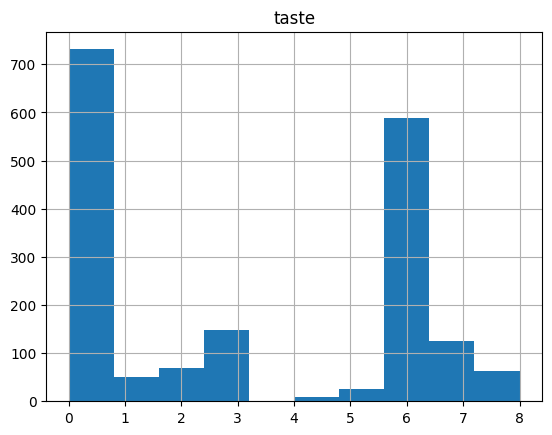

In [7]:
print(df.taste.value_counts())
df.hist(column='taste')

## Data pre-processing

In [8]:
from skfp.fingerprints import AtomPairFingerprint
atom_pair_fingerprint = AtomPairFingerprint()
fp = atom_pair_fingerprint.transform(df.smiles)
X = pd.DataFrame(fp)
X

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1,1,1,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1805,1,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1807,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Simple approach

### Train test split

In [9]:
from skfp.fingerprints import ECFPFingerprint
from collections import Counter
from skfp.model_selection import scaffold_train_test_split
from sklearn.model_selection import train_test_split

def scaffold_train_test_split_data(X = df.smiles, y = df.taste):
    mols_train, mols_test, y_train, y_test = scaffold_train_test_split(X, y, test_size=0.2)
    print(f'Classes distribution train: {sorted(Counter(y_train).items())}')
    print(f'Classes distribution test: {sorted(Counter(y_test).items())}')

    ecfp_fp = ECFPFingerprint()
    X_train = ecfp_fp.transform(mols_train)
    X_test = ecfp_fp.transform(mols_test)

    return X_train, X_test, y_train, y_test 

def train_test_split_data(X = df.smiles, y = df.taste):
    ecfp_fp = ECFPFingerprint()
    X = ecfp_fp.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    print(f'Classes distribution train: {sorted(Counter(y_train).items())}')
    print(f'Classes distribution test: {sorted(Counter(y_test).items())}')

    return X_train, X_test, y_train, y_test 

### Model

In [10]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def train_model(X_train, X_test, y_train, y_test):

    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = balanced_accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8])
    print(f"Balanced accuracy: {acc:.2%}")

    return cm



In [11]:
X_train, X_test, y_train, y_test = train_test_split_data(df.smiles, df.taste)
cm = train_model(X_train, X_test, y_train, y_test)

Classes distribution train: [(0, 596), (1, 38), (2, 52), (3, 115), (4, 7), (5, 19), (6, 471), (7, 100), (8, 49)]
Classes distribution test: [(0, 135), (1, 12), (2, 17), (3, 34), (4, 1), (5, 6), (6, 118), (7, 25), (8, 14)]
Balanced accuracy: 54.06%


### Confusion matrix

In [12]:
import matplotlib.pyplot as plt

def plot_cm(cm):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8])
    cm_display.plot()
    plt.show() 

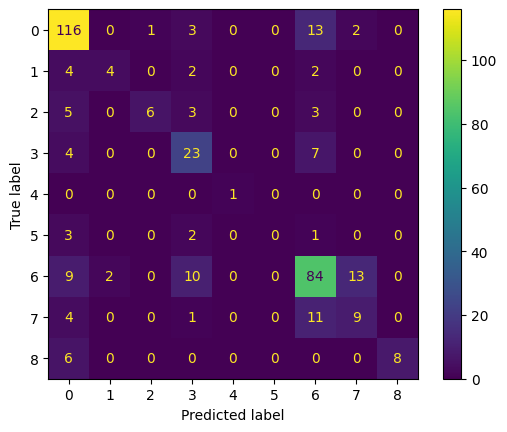

In [13]:
plot_cm(cm)

## Balancing classes

In [14]:
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

def balance_classes(X, y):
    sme = SMOTE()

    print(f'Classes distribution : {sorted(Counter(y).items())}')
    X_resampled, y_resampled = sme.fit_resample(X, y)
    print(f'Classes distribution : {sorted(Counter(y_resampled).items())}')

    return X_resampled, y_resampled

In [15]:
X_resampled, y_resampled = balance_classes(X_train, y_train)

Classes distribution : [(0, 596), (1, 38), (2, 52), (3, 115), (4, 7), (5, 19), (6, 471), (7, 100), (8, 49)]
Classes distribution : [(0, 596), (1, 596), (2, 596), (3, 596), (4, 596), (5, 596), (6, 596), (7, 596), (8, 596)]


In [16]:
cm_2 = train_model(X_resampled, X_test, y_resampled, y_test)

Balanced accuracy: 59.17%


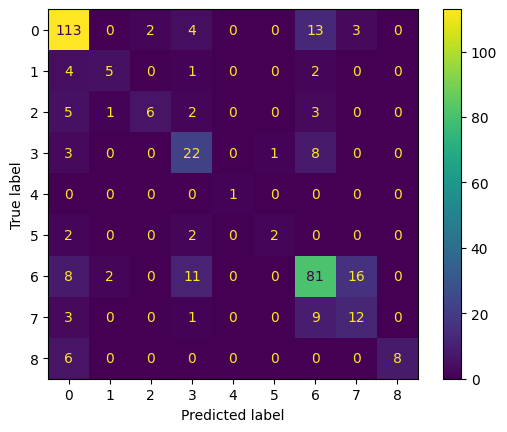

In [17]:
plot_cm(cm_2)

## Feature engineering

### Variance threshold

In [18]:
from sklearn.feature_selection import VarianceThreshold

def select_features(X, threshold = 0.05):
    
    print(X.shape)
    selector = VarianceThreshold(threshold=threshold)
    X = selector.fit_transform(X)
    print(X.shape)

    return X

In [19]:
def _train_test_split_data(X = df.smiles, y = df.taste):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    print(f'Classes distribution train: {sorted(Counter(y_train).items())}')
    print(f'Classes distribution test: {sorted(Counter(y_test).items())}')

    return X_train, X_test, y_train, y_test 

In [25]:
df.head()
Chem.MolFromSmiles(smiles)

,molecule_id,smiles,taste
0,train_0,C=C1CC23CCC4C(C)(C(=O)O)CCCC4(C)C2CCC1(OC1OC(C...,6
1,train_1,Nc1ccccc1NS(=O)(=O)[O-].[Na+],3
2,train_2,O=C1NS(=O)(=O)c2cc(O)ccc21,6
3,train_3,OCC1OC(Oc2ccc3ccccc3c2)C(O)C(O)C1O,0
4,train_4,CCC1(C2=CCCCCC2)C(=O)NC(=O)NC1=O,0


In [30]:
## Aproach 1 - MACCS
from rdkit.Chem import MACCSkeys
from rdkit import Chem

maccs = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)) for x in df['smiles']]

maccs_lists = [list(l) for l in maccs]

maccs_name = [f'MACCS_{i}' for i in range(167)]

maccs_df = pd.DataFrame(maccs_lists, index=df.index, columns=maccs_name)

maccs_df.shape
maccs_df.head()

,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,MACCS_9,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,1,1,1,0


In [ ]:
## Aproach 2 - ECFPFingerprint


## Pipeline draft

Classes distribution : [(0, 731), (1, 50), (2, 69), (3, 149), (4, 8), (5, 25), (6, 589), (7, 125), (8, 63)]
Classes distribution : [(0, 731), (1, 731), (2, 731), (3, 731), (4, 731), (5, 731), (6, 731), (7, 731), (8, 731)]
(6579, 167)
(6579, 115)
Classes distribution train: [(0, 563), (1, 592), (2, 581), (3, 588), (4, 593), (5, 587), (6, 591), (7, 578), (8, 590)]
Classes distribution test: [(0, 168), (1, 139), (2, 150), (3, 143), (4, 138), (5, 144), (6, 140), (7, 153), (8, 141)]
Balanced accuracy: 90.03%


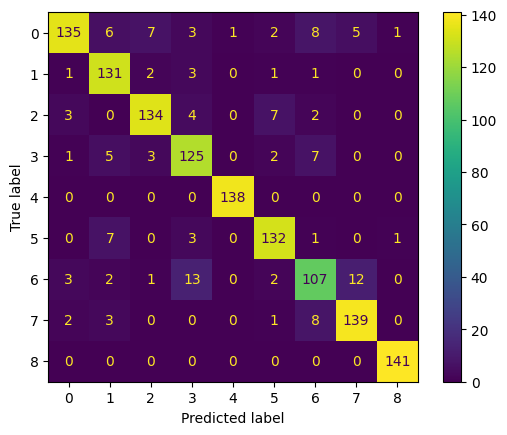

In [31]:
## TODO Jak przez to wszystko przepuścić teraz test dataset (główny problem - selekcja atrybutów)?

# 1) Zmień encoding
# ecfp_fp = ECFPFingerprint() #zmień rozmiar fingerprinta MACCS
# X = ecfp_fp.transform(df.smiles)
# y = df.taste
maccs = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)) for x in df['smiles']]
maccs_lists = [list(l) for l in maccs]
maccs_name = [f'MACCS_{i}' for i in range(167)]
X = pd.DataFrame(maccs_lists, index=df.index, columns=maccs_name)
y = df.taste

# 2) Zbalansuj klasy
X_resampled, y_resampled = balance_classes(X, y)

# 3) Wyselekcjonuj atrybuty
X_selected = select_features(X_resampled, threshold = 0.05)

# 4) Train test split
X_train, X_test, y_train, y_test  = _train_test_split_data(X_selected, y_resampled)

# 5) Train model
cm_3 = train_model(X_train, X_test, y_train, y_test)
plot_cm(cm_3)

## Model building

## Model training

## Making predictions

## Visualising results
